In [24]:
import argusDB as adb
import zandmotor as zm
from camera import Camera, load_image, Regionofinterest
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import projections as proj
from IPython.core.display import display, HTML

%matplotlib notebook
plt.rcParams['figure.dpi'] = 100

## Initialize things

In [25]:
# connect to argus and image data base
argusdb, imagedb = adb.Argusdb(), adb.Imagedb()


#Specify site, camera and period of interest
site, camID = 'zandmotor', 'ZMXX01C'
t = {'start' : datetime(2014, 1, 1), 'end' : datetime(2014, 1, 2)}


# load site info and init class which allows for rotation to/from local coord sytem
siteInfo = argusdb.get_site(name = site)[0]
siteProj = proj.Argusproj(x0 = siteInfo['x'], y0 = siteInfo['y'], 
                               epsg = siteInfo['EPSG'], rotation = siteInfo['rotation']) 


# Load camera info and init camera class
camInfo = argusdb.get_camera(camID = camID)[0]
camClass = Camera(camInfo['K'], camInfo['Drad'], camInfo['Dtan'], camInfo['Nu'], camInfo['Nv'])


# extract urls of images corresponding to camera from database
df_images = imagedb.image_query('zandmotor', cameras = [int(''.join(filter(lambda i: i.isdigit(), camID)))], 
                                   types = ['snap'], tlims = [t['start'], t['end']])
df_images.dropna(inplace = True)

display(HTML(df_images.to_html()))

,1
,snap
2014-01-01 07:30:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388561401.Wed.J...
2014-01-01 08:00:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388563201.Wed.J...
2014-01-01 08:30:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388565001.Wed.J...
2014-01-01 09:00:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388566801.Wed.J...
2014-01-01 09:30:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388568601.Wed.J...
2014-01-01 10:00:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388570402.Wed.J...
2014-01-01 10:30:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388572202.Wed.J...
2014-01-01 11:00:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388574001.Wed.J...
2014-01-01 11:30:00+00:00,/zandmotor/2014/c1/001_Jan.01/1388575801.Wed.J...


## Rectify cameras

,geomID,camID,valid,gcpCounts
0,19705,ZMXX01C,1361887207,15
1,19721,ZMXX01C,1361890807,15
2,19749,ZMXX01C,1366603201,14
3,19847,ZMXX01C,1376047801,13
4,19849,ZMXX01C,1377144007,12
5,19851,ZMXX01C,1378976407,10
6,19853,ZMXX01C,1380951007,10
7,19855,ZMXX01C,1384324207,10
8,19859,ZMXX01C,1385881208,10
9,19861,ZMXX01C,1387524608,10


,gcpID,u,v,x,y,z
0,ZMXX0063,515.100420,671.637451,-40.474952,-380.039043,1.34
1,ZMXX0061,1844.028865,441.581662,-251.723266,-625.570227,1.42
2,ZMXX0060,2304.653622,434.630336,-322.922831,-626.204914,2.67
3,ZMXX0028,67.898448,833.835058,-4.705061,-281.190415,1.89
4,ZMXX0025,1237.575113,962.600097,-59.495140,-223.019356,2.66
5,ZMXX0024,1787.557406,923.871281,-90.547126,-227.457522,2.56
6,ZMXX0023,2280.820505,904.010349,-117.818379,-228.436086,2.56
7,ZMXX0003,187.378396,1911.290589,-4.430693,-100.944528,4.91
8,ZMXX0002,1247.340071,1900.036061,-26.702961,-95.248172,5.10
9,ZMXX0001,2201.376779,1947.702296,-45.582170,-87.683756,5.09


<IPython.core.display.Javascript object>


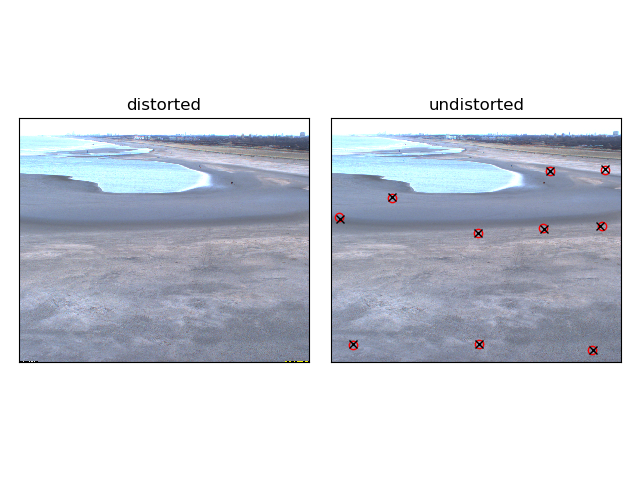

Projection error = 7.06


In [20]:
# Get list of geometry solutions which can be used to rectify camera
geomList = argusdb.get_geometry_list(camID = camID)
display(HTML((geomList.to_html())))

        
#load a geometry solution and get image and real world coordinates of control points
gcps = argusdb.get_geometry(geomID = 19861)
display(HTML((gcps.to_html())))        
        
uv, xyz = gcps.loc[:, ('u', 'v')].values, gcps.loc[:, ('x', 'y', 'z')].values
camClass.rectify(xyz, uv)


# project gcp coordinates back into image
uvProj = camClass.xyz2uv(xyz)

# load an image 
images = {}
imageURL = adb._baseurl + df_images.loc[df_images.index[10], (1, 'snap')]
images['distorted'] = load_image(imageURL)

# undistort image using camera class
images['undistorted'] = camClass.undistortimg(images['distorted'])


#plot images
f, (ax1, ax2) = plt.subplots(1, 2)
for ax, key in zip((ax1, ax2), ('distorted', 'undistorted')):
    
    if key == 'undistorted':
       plt.plot(*uv.T, 'or', markerfacecolor = 'none')
       plt.plot(*uvProj.T, 'xk')
    
    ax.imshow(images[key])
    ax.set_title(key)
    ax.set_xticks([]), ax.set_yticks([])
f.tight_layout()
        
print('Projection error = {0:.2f}'.format(camClass.proj_error))

## Examine the field of view of the camera 

<IPython.core.display.Javascript object>


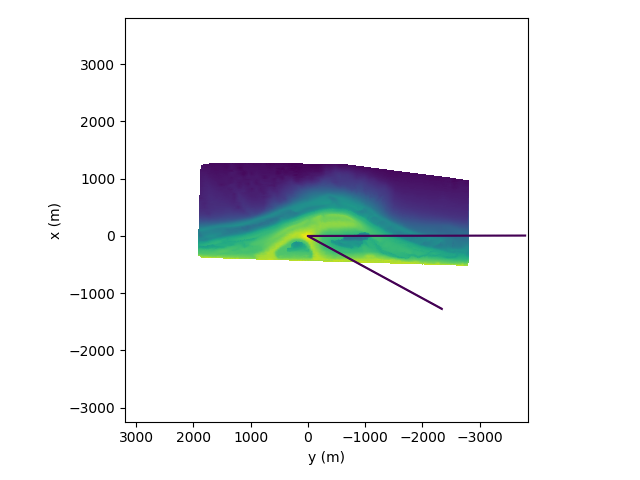

In [22]:
# load a topographic survey and illustrate field of view of camera
gpsData = {}
gpsData['x'], gpsData['y'], gpsData['z'] = zm.get_gps(t['start'], to_grid = True)[0: -1]

# transform x and y coordinates to local cooridnate systems of beach
gpsData['x'], gpsData['y'] = siteProj.toargus(*np.meshgrid(gpsData['x'], gpsData['y']))


#illustrate field of view of camera
plt.figure()
plt.pcolormesh(gpsData['y'], gpsData['x'], gpsData['z'], cmap = plt.cm.viridis)
plt.contour(gpsData['y'], gpsData['x'],
               camClass.xyinfov(gpsData['x'], gpsData['y']).astype(float), 
                  '--r', levels = [0.99])
plt.gca().invert_xaxis()
plt.ylim([-400, 1000])
plt.xlim([2000, -3000])
plt.xlabel('y (m)')
plt.ylabel('x (m)')
plt.axis('scaled')
plt.tight_layout()

# make kd-tree for quick look up topo values    
xytreeARG = zm.XYTree(gpsData['x'], gpsData['y'], gpsData['z'])    



## Extract plan view image of portion of beach

<IPython.core.display.Javascript object>


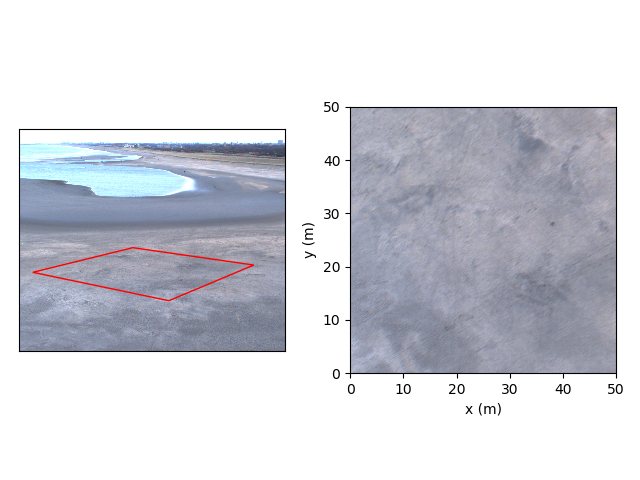

In [23]:
def box(width):
    hwidth = width/2
    xy = np.array([[-hwidth, hwidth], [hwidth, hwidth], 
                          [hwidth, -hwidth],  [-hwidth, -hwidth]])
    return xy

#define centre of area ..
xy = np.array([[-40, -155]])
xyz = np.column_stack((xy, xytreeARG.get_z(*xy.T))).reshape(-1, 1, 3)

xyBox = xy + siteProj._rotate(box(50))

bbox = {}
bbox['xyz'] = np.column_stack((xyBox, xytreeARG.get_z(*xyBox.T)))
bbox['uv'] = camClass.xyz2uv(bbox['xyz'])


planview = Regionofinterest(corners = bbox['uv'].data)\
                              .warpPerspective(images['undistorted'], shape = (768, 768))[0]


f, (ax1, ax2) = plt.subplots(1, 2)
ax1.fill(*bbox['uv'].data.T, fill = None, edgecolor = 'r')
ax1.imshow(images['undistorted'])
ax1.set_xticks([]), ax1.set_yticks([])

ax2.imshow(planview, extent = [0, 50, 0, 50])
ax2.set_xticks(np.linspace(0, 50, 6))
ax2.set_yticks(np.linspace(0, 50, 6))
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
f.tight_layout()

In [27]:
siteInfo

{'EPSG': '28992',
 'TZname': 'MET',
 'TZoffset': 60,
 'degFromN': 310,
 'name': 'zandmotor',
 'rotation': 140,
 'seq': 110,
 'siteID': 'ZMXXXXX',
 'x': 72502,
 'y': 452074}